### Model Implementation - Nature Sound Classification

In [20]:
#Importing the libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from sklearn import metrics
from sklearn.metrics import classification_report
from tqdm import tqdm

In [21]:
# Set random seed for Python's built-in random number generator
import random
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for TensorFlow
tf.random.set_seed(random_seed)

In [22]:
#Read each image and resize to 224x224
DATADIR = '/usr/cs/grad/masters/2025/ncherian/nature_sound/cwt_1'
labels = ["10","11","12","13","14","16","17","18","19"]
dataset = []
img_size = (224,224)
for category in tqdm(labels):
		path = os.path.join(DATADIR,category)
		class_num = labels.index(category)
		for img in os.listdir(path):
			try :
				img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
				image_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
				new_array = cv2.resize(image_rgb, img_size)
				dataset.append([new_array, class_num])
			except Exception as e:
				print(f"Error processing image {img} in category {category}: {e}")


X = [] #features
Y = [] #labels

for features, label in dataset:
	X.append(features)
	Y.append(label)

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:24<00:00,  2.69s/it]


In [23]:
print(f"Number of samples: {len(X)}")
print(f"Feature shape: {X[0].shape}, Label example: {Y[0]}")

Number of samples: 3542
Feature shape: (224, 224, 3), Label example: 0


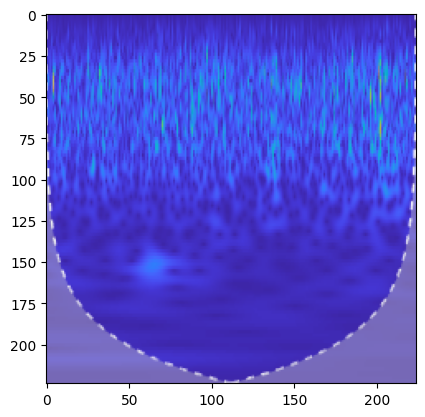

In [24]:
#Display sample time frequency image
import matplotlib.pyplot as plt
 
plt.imshow(X[1])

In [25]:
#Split dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

X_train = np.array(X_train).reshape(-1, img_size[0], img_size[1], 3)
Y_train = np.array(Y_train).reshape(-1,)

X_test = np.array(X_test).reshape(-1,  img_size[0], img_size[1], 3)
Y_test = np.array(Y_test).reshape(-1,)

### VGGNet19 Model

In [26]:
base_model = tf.keras.applications.VGG19(weights="imagenet", include_top=False,
                                                input_tensor=None, classes=9, input_shape=(224, 224, 3))
base_model.trainable = False

# Define normalization layer
normalization_layer = tf.keras.layers.Normalization()

# Create the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = normalization_layer(inputs)  # Normalize input data
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 224, 224, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,029,008 (76.40 MB)

 Trainable params: 4,617 (18.04 KB)

 Non-trainable params: 20,024,391 (76.39 MB)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=5,                # Number of epochs to wait for improvement
    verbose=1,                 # Logs a message when training stops
    restore_best_weights=True  # Restores the best model weights
)

In [28]:
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
   optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'])


model_vgg = model.fit(X_train, Y_train, epochs =30, shuffle = True,
                    validation_split = 0.1,callbacks=[early_stopping])

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 611ms/step - accuracy: 0.1381 - loss: 4.1272 - val_accuracy: 0.1761 - val_loss: 3.0419
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 604ms/step - accuracy: 0.2033 - loss: 3.0290 - val_accuracy: 0.2535 - val_loss: 2.4199
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 605ms/step - accuracy: 0.2822 - loss: 2.4633 - val_accuracy: 0.3486 - val_loss: 2.0193
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 601ms/step - accuracy: 0.3489 - loss: 2.0923 - val_accuracy: 0.4296 - val_loss: 1.7488
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 606ms/step - accuracy: 0.4004 - loss: 1.8374 - val_accuracy: 0.4577 - val_loss: 1.5524
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 597ms/step - accuracy: 0.4466 - loss: 1.6505 - val_accuracy: 0.5000 - val_loss: 1.4023
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 598ms/step - accuracy: 0.4816 - loss: 1.5060 - val_accuracy: 0.5317 - val_loss: 1.2837
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 596ms/step - accuracy: 0.5204 - loss: 1.3903 - val_accu

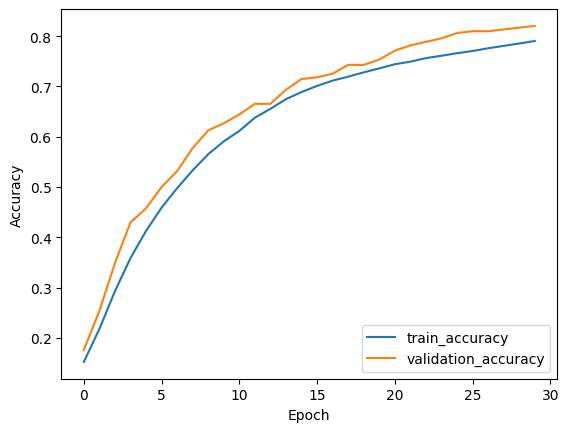

In [29]:
plt.plot(model_vgg.history['accuracy'], label='train_accuracy')
plt.plot(model_vgg.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')
plt.show()

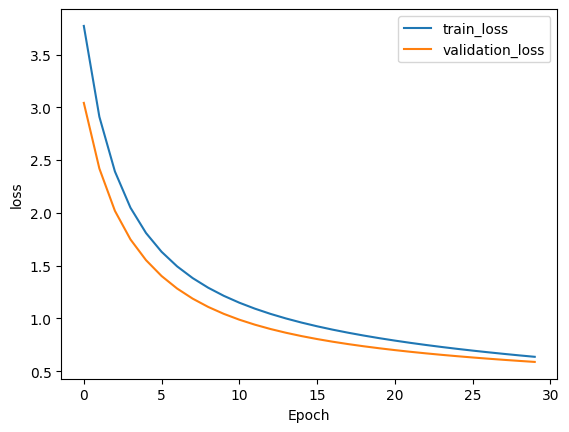

In [30]:
plt.plot(model_vgg.history['loss'], label='train_loss')
plt.plot(model_vgg.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step - accuracy: 0.7325 - loss: 0.8465
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step
test_accuracy: 72.35543018335684 

test_loss: 0.8510528802871704 

              precision    recall  f1-score   support

           0       0.72      0.69      0.70       100
           1       0.69      0.76      0.73        85
           2       0.79      0.79      0.79        87
           3       0.71      0.61      0.66        72
           4       0.62      0.73      0.67        77
           5       0.78      0.57      0.66        74
           6       0.70      0.78      0.74        63
           7       0.88      0.71      0.79        83
           8       0.68      0.88      0.77        68

    accuracy                           0.72       709
   macro avg       0.73      0.72      0.72       709
weighted avg       0.73      0.72      0.72       709



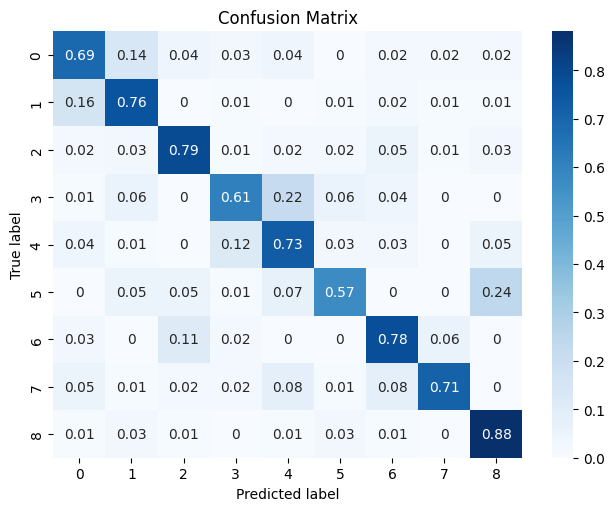

In [14]:

# Calculate the desired metrics
test_loss, test_acc = model.evaluate(X_test, Y_test)

# Model prediction provides probabilities of the input class
# Based on the probabilities the corresponding class category is determined.
Y_te = np.array(tf.math.argmax(model.predict(X_test),1))
cm = tf.math.confusion_matrix(Y_test, Y_te)
# Calculate the accuracy metrics
acc = metrics.accuracy_score(Y_test, Y_te)

con_mat = tf.math.confusion_matrix(labels=Y_test, predictions=Y_te).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
# Classification metrics and report
classReport = classification_report(Y_test, Y_te)

# Print and save all the metrics
print("test_accuracy:", acc*100, "\n")
print("test_loss:", test_loss, "\n")
print(classReport)
classes = ["0","1","2","3","4","5","6","7","8"]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)
figure = plt.figure()
sns.heatmap(con_mat_df, annot=True, cmap="Blues")
plt.tight_layout()
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### EfficientNetV2B0 Model

In [33]:
base_model = tf.keras.applications.EfficientNetV2B0(weights="imagenet", include_top=False,
                                                input_tensor=None, classes=9, input_shape=(224, 224, 3))
base_model.trainable = False

# Define normalization layer
normalization_layer = tf.keras.layers.Normalization()

# Create the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = normalization_layer(inputs)  # Normalize input data
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_5 (Normalization) │ (None, 224, 224, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,930,848 (22.62 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 5,919,319 (22.58 MB)

In [34]:
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
   optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'])


model_efficientnet = model.fit(X_train, Y_train, epochs =40, shuffle = True,
                    validation_split = 0.05,callbacks=[early_stopping])

Epoch 1/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - accuracy: 0.1454 - loss: 2.2369 - val_accuracy: 0.3099 - val_loss: 1.9716
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.3711 - loss: 1.9092 - val_accuracy: 0.5000 - val_loss: 1.7313
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.5153 - loss: 1.7174 - val_accuracy: 0.6056 - val_loss: 1.5568
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.5831 - loss: 1.5585 - val_accuracy: 0.6620 - val_loss: 1.4203
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.6144 - loss: 1.4477 - val_accuracy: 0.7042 - val_loss: 1.3156
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.6328 - loss: 1.3519 - val_accuracy: 0.7324 - val_loss: 1.2307
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.6628 - loss: 1.2772 - val_accuracy: 0.7324 - val_loss: 1.1619
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.6801 - loss: 1.2061 - val_accu

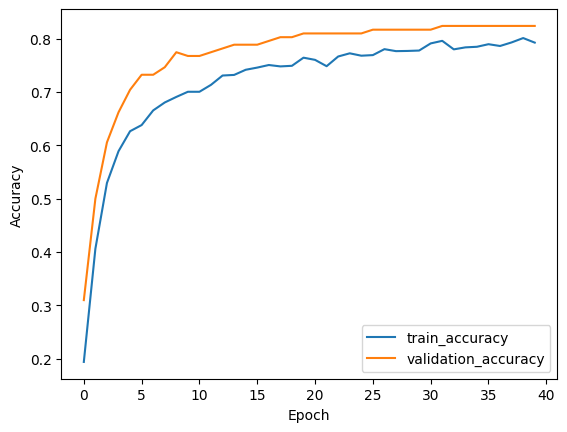

In [35]:
plt.plot(model_efficientnet.history['accuracy'], label='train_accuracy')
plt.plot(model_efficientnet.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')
plt.show()

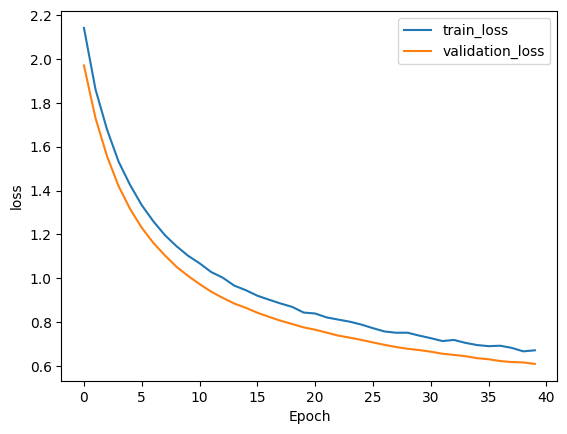

In [36]:
plt.plot(model_efficientnet.history['loss'], label='train_loss')
plt.plot(model_efficientnet.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.8165 - loss: 0.6479
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step
test_accuracy: 81.80535966149506 

test_loss: 0.6415736675262451 

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       100
           1       0.75      0.89      0.82        85
           2       0.88      0.92      0.90        87
           3       0.91      0.72      0.81        72
           4       0.78      0.84      0.81        77
           5       0.79      0.70      0.74        74
           6       0.86      0.90      0.88        63
           7       0.86      0.75      0.80        83
           8       0.76      0.84      0.80        68

    accuracy                           0.82       709
   macro avg       0.82      0.82      0.82       709
weighted avg       0.82      0.82      0.82       709



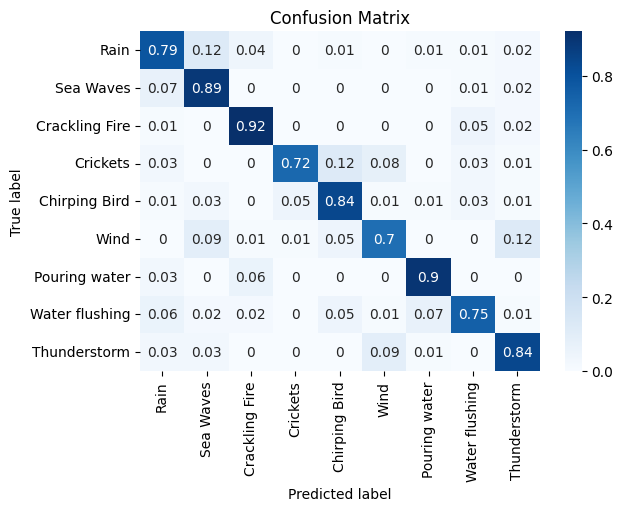

In [37]:

# Calculate the desired metrics
test_loss, test_acc = model.evaluate(X_test, Y_test)

# Model prediction provides probabilities of the input class
# Based on the probabilities the corresponding class category is determined.
Y_te = np.array(tf.math.argmax(model.predict(X_test),1))
cm = tf.math.confusion_matrix(Y_test, Y_te)
# Calculate the accuracy metrics
acc = metrics.accuracy_score(Y_test, Y_te)

con_mat = tf.math.confusion_matrix(labels=Y_test, predictions=Y_te).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
# Classification metrics and report
classReport = classification_report(Y_test, Y_te)

# Print and save all the metrics
print("test_accuracy:", acc*100, "\n")
print("test_loss:", test_loss, "\n")
print(classReport)
classes = ["Rain","Sea Waves","Crackling Fire","Crickets","Chirping Bird","Wind","Pouring water","Water flushing","Thunderstorm"]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)
figure = plt.figure()
sns.heatmap(con_mat_df, annot=True, cmap="Blues")
plt.tight_layout()
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### ResNet50 Model

In [55]:
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False,
                                                input_tensor=None, classes=9, input_shape=(224, 224, 3))
base_model.trainable = False

# Define normalization layer
normalization_layer = tf.keras.layers.Normalization()

# Create the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = normalization_layer(inputs)  # Normalize input data
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_8 (Normalization) │ (None, 224, 224, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │        18,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,606,160 (90.05 MB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 23,587,719 (89.98 MB)

In [56]:
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
   optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy'])


model_resnet = model.fit(X_train, Y_train, epochs =40, shuffle = True,
                    validation_split = 0.1,callbacks=[early_stopping])

Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 297ms/step - accuracy: 0.1668 - loss: 2.3756 - val_accuracy: 0.4613 - val_loss: 1.6637
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.5000 - loss: 1.5803 - val_accuracy: 0.6127 - val_loss: 1.3324
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - accuracy: 0.6296 - loss: 1.2994 - val_accuracy: 0.7042 - val_loss: 1.1482
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - accuracy: 0.6736 - loss: 1.1345 - val_accuracy: 0.7183 - val_loss: 1.0288
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 271ms/step - accuracy: 0.7207 - loss: 1.0229 - val_accuracy: 0.7359 - val_loss: 0.9445
Epoch 6/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 278ms/step - accuracy: 0.7444 - loss: 0.9413 - val_accuracy: 0.7430 - val_loss: 0.8813
Epoch 7/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - accuracy: 0.7603 - loss: 0.8782 - val_accuracy: 0.7535 - val_loss: 0.8317
Epoch 8/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - accuracy: 0.7751 - loss: 0.8274 - val_accu

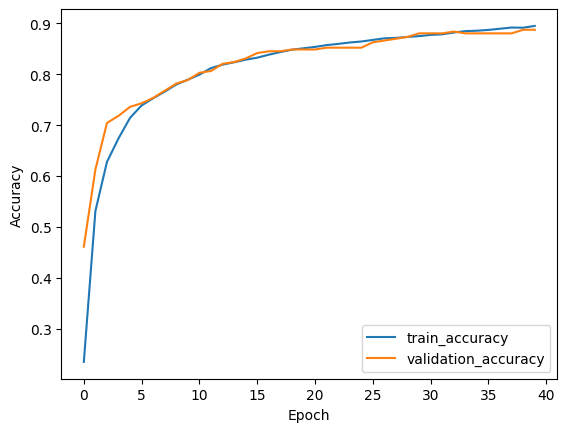

In [57]:
plt.plot(model_resnet.history['accuracy'], label='train_accuracy')
plt.plot(model_resnet.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')
plt.show()

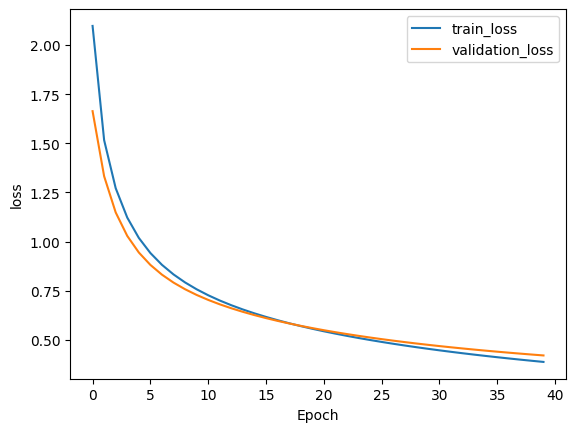

In [58]:
plt.plot(model_resnet.history['loss'], label='train_loss')
plt.plot(model_resnet.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.8461 - loss: 0.4588
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step
test_accuracy: 85.75458392101551 

test_loss: 0.44499772787094116 

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       100
           1       0.83      0.87      0.85        85
           2       0.88      0.92      0.90        87
           3       0.92      0.90      0.91        72
           4       0.81      0.84      0.83        77
           5       0.83      0.78      0.81        74
           6       0.91      0.94      0.92        63
           7       0.87      0.83      0.85        83
           8       0.77      0.81      0.79        68

    accuracy                           0.86       709
   macro avg       0.86      0.86      0.86       709
weighted avg       0.86      0.86      0.86       709



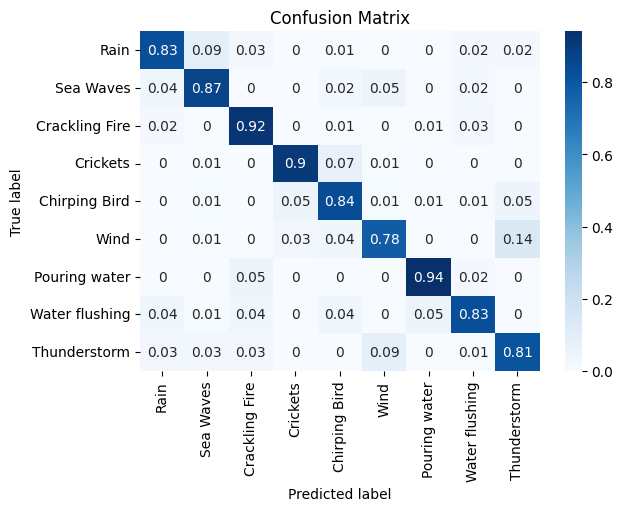

In [59]:

# Calculate the desired metrics
test_loss, test_acc = model.evaluate(X_test, Y_test)

# Model prediction provides probabilities of the input class
# Based on the probabilities the corresponding class category is determined.
Y_te = np.array(tf.math.argmax(model.predict(X_test),1))
cm = tf.math.confusion_matrix(Y_test, Y_te)
# Calculate the accuracy metrics
acc = metrics.accuracy_score(Y_test, Y_te)

con_mat = tf.math.confusion_matrix(labels=Y_test, predictions=Y_te).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
# Classification metrics and report
classReport = classification_report(Y_test, Y_te)

# Print and save all the metrics
print("test_accuracy:", acc*100, "\n")
print("test_loss:", test_loss, "\n")
print(classReport)
classes = ["Rain","Sea Waves","Crackling Fire","Crickets","Chirping Bird","Wind","Pouring water","Water flushing","Thunderstorm"]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)
figure = plt.figure()
sns.heatmap(con_mat_df, annot=True, cmap="Blues")
plt.tight_layout()
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Vanilla CNN Model

In [49]:
from tensorflow.keras import layers, regularizers

def res_net_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='swish', padding='same')(input_data)
    x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('swish')(x)
    return x

def createModel(img_size):
    # Model construction

    kernelSize = (8,8)
    maxpoolSize = (6,6)

    inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3))
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2D(16, kernelSize, padding='same', activation='relu6')(x)
    x = layers.MaxPooling2D(pool_size = maxpoolSize, strides=None)(x)

    num_res_net_blocks = 1
    for i in range(num_res_net_blocks):
        x = res_net_block(x, 16, 8)

    x = layers.Conv2D(32, kernelSize, padding='same', activation='relu6')(x)
    x = layers.MaxPooling2D(pool_size = maxpoolSize, strides=None)(x)
    x = layers.Conv2D(64, kernelSize, padding='same', activation='relu6')(x)
    x = layers.MaxPooling2D(pool_size = maxpoolSize, strides=None)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(9, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

# Create the model
img_size = (224, 224)  # Update this based on your image size

model = createModel(img_size)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         12 │ input_layer_12[0… │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 224, 224,  │      3,088 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 37, 37,    │          0 │ conv2d_94[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 37, 37,    │     16,400 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 37, 37,    │     16,400 │ conv2d_95[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 37, 37,    │     16,400 │ conv2d_96[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 37, 37,    │          0 │ conv2d_97[0][0],  │
│                     │ 16)               │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 37, 37,    │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 37, 37,    │     32,800 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 6, 6, 32)  │          0 │ conv2d_98[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 6, 6, 64)  │    131,136 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 1, 1, 64)  │          0 │ conv2d_99[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 9)         │        585 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 216,821 (846.96 KB)

 Trainable params: 216,815 (846.93 KB)

 Non-trainable params: 6 (24.00 B)

In [50]:
# Model compile
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

# Model fit/train
history = model.fit(X_train, Y_train, epochs=20, shuffle = True, batch_size=64, validation_split= 0.1)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 276ms/step - accuracy: 0.3061 - loss: 1.8512 - val_accuracy: 0.0880 - val_loss: 5.3271
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.6751 - loss: 0.9558 - val_accuracy: 0.1690 - val_loss: 4.5517
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - accuracy: 0.7846 - loss: 0.6451 - val_accuracy: 0.2958 - val_loss: 2.5297
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.8446 - loss: 0.4723 - val_accuracy: 0.4120 - val_loss: 1.9517
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.8895 - loss: 0.3364 - val_accuracy: 0.5634 - val_loss: 1.2055
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.9235 - loss: 0.2411 - val_accuracy: 0.7289 - val_loss: 0.8178
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.9363 - loss: 0.1968 - val_accuracy: 0.8486 - val_loss: 0.4032
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.9412 - loss: 0.1664 - val_accu

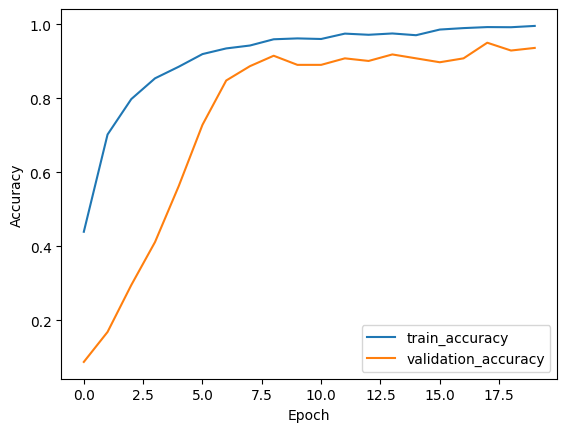

In [51]:
# Accuracy curves
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

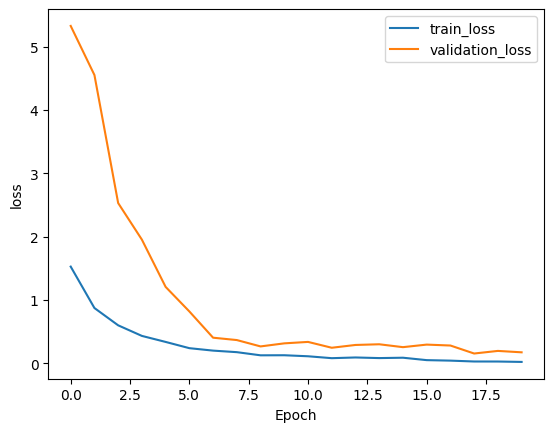

In [52]:
# Loss curves
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

In [53]:
# Calculate the desired metrics
test_loss, test_acc = model.evaluate(X_test, Y_test)

# Model prediction provides probabilities of the input class
# Based on the probabilities the corresponding class category is determined.
Y_te = np.array(tf.math.argmax(model.predict(X_test),1))

# Calculate the accuracy metrics
acc = metrics.accuracy_score(Y_test, Y_te)

# Classification metrics and report
classReport = classification_report(Y_test, Y_te)

# Print and save all the metrics
print("test_accuracy:", acc*100, "\n")
print("test_loss:", test_loss, "\n")
print(classReport)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9195 - loss: 0.2918
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
test_accuracy: 91.9605077574048 

test_loss: 0.2889502942562103 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       100
           1       0.94      0.98      0.96        85
           2       0.92      0.99      0.96        87
           3       0.97      0.93      0.95        72
           4       0.92      0.92      0.92        77
           5       0.85      0.97      0.91        74
           6       0.95      0.87      0.91        63
           7       0.93      0.86      0.89        83
           8       0.95      0.78      0.85        68

    accuracy                           0.92       709
   macro avg       0.92      0.92      0.92       709
weighted avg       0.92      0.92      0.92       709



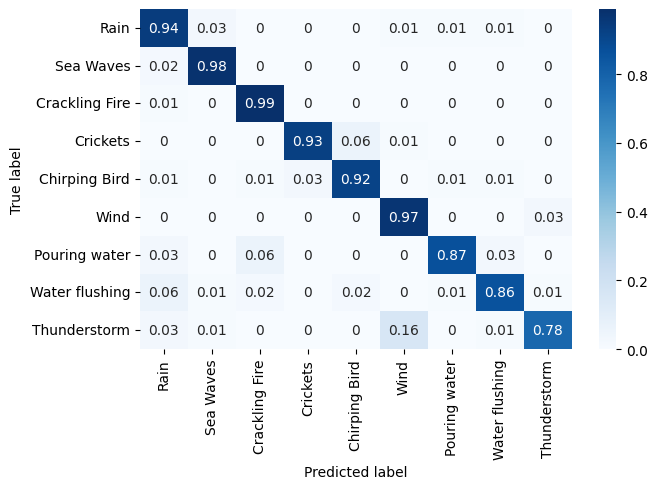

In [54]:
# Plot the confusion matrix
con_mat = tf.math.confusion_matrix(labels=Y_test, predictions=Y_te).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes = ["Rain","Sea Waves","Crackling Fire","Crickets","Chirping Bird","Wind","Pouring water","Water flushing","Thunderstorm"]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)
figure = plt.figure(figsize=(7,5))
sns.heatmap(con_mat_df, annot=True, cmap="Blues")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()